In [1]:
import xml.etree.ElementTree as ET
import numpy as np
import cv2
import random
import os


In [9]:
CLASSES = ['person', 'bird', 'cat', 'cow', 'dog', 'horse', 'sheep',
           'aeroplane', 'bicycle', 'boat', 'bus', 'car', 'motorbike', 'train',
           'bottle', 'chair', 'diningtable', 'pottedplant', 'sofa', 'tvmonitor']
GL_NUMBBOX = 2
GL_NUMGRID = 7       
print(len(CLASSES))

20


In [3]:
def convert(size, box):
    """
    将标注数据中的左上角，右下角的坐标点的格式转换成 
    中心点 + w,h，并进行归一会
    """
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x * dw
    y = y * dh
    w = w * dw
    h = h * dh
    return (x, y, w, h)

In [4]:
in_file = "/data/data/voc/VOCdevkit/VOC2007/Annotations/000005.xml"
tree = ET.parse(in_file)
root = tree.getroot()
size = root.find('size')
w = int(size.find('width').text)
h = int(size.find('height').text)

print(w,h)
bb = [1, 2, 3, 4]
abc = " ".join([str(a) for a in bb])
print(abc)

500 375
1 2 3 4


In [5]:
def convert_annotation(anno_dir, image_id, labels_dir):
    in_file = open(os.path.join(anno_dir,  'Annotations/%s' % (image_id)))
    image_id = image_id.split('.')[0]
    out_file = open(os.path.join(labels_dir, "%s.txt" %(image_id)), 'w')
    tree = ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        # 这里如何是比较难的物体就不执行检测
        if cls not in CLASSES or int(difficult) == 1:
            continue
        
        cls_id = CLASSES.index(cls)
        xmlbox = obj.find('bndbox')
        points = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), 
                    float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
        bb = convert((w, h), points)
        # 将序列中的元素以指定的字符连接生成一个新的字符串: 这里用空格来连接
        out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + "\n")
        

In [7]:
def make_label_txt(anno_dir, labels_dir):
    file_names = os.listdir(os.path.join(anno_dir, 'Annotations'))
    for file in file_names:
        # print(file)
        convert_annotation(anno_dir, file, labels_dir)

In [ ]:
# 生成对应的图片txt文档
anno_dir = "/data/data/voc/VOCdevkit/VOC2007"
labels_dir = "/data/data/voc/VOCdevkit/VOC2007/labels"
make_label_txt(anno_dir, labels_dir)

In [18]:
import matplotlib.pyplot as plt

def show_labels_img(img_dir, label_dir, imgname):
    img = cv2.imread(os.path.join(img_dir,imgname + ".jpg"))
    h, w = img.shape[:2]
    print("width:%s, hegiht: %s" %(w, h))
    with open(os.path.join(label_dir, imgname + ".txt"), 'r') as flabel:
        for label in flabel:
            label_info = label.split(' ')
            label, x, y, box_w, box_h = [float(x.strip()) for x in label_info]
            print(CLASSES[int(label)])
            pt1 = (int(x * w - box_w * w / 2), int(y * h - box_h * h / 2))
            pt2 = (int(x * w + box_w * w / 2), int(y * h + box_h * h / 2))
            cv2.putText(img, CLASSES[int(label)], pt1, cv2.FONT_HERSHEY_SIMPLEX,0.5, (0,0,255))
            cv2.rectangle(img, pt1, pt2, (0,0,255), 2)
    img = img[...,::-1]
    plt.imshow(img)

width:500, hegiht: 375
cow
cow
bird
bird
bird


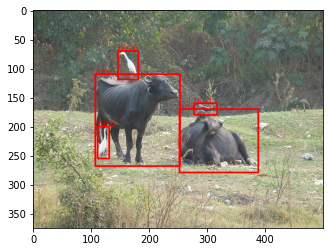

In [24]:
# 测试相关的数据
img_dir = "/data/data/voc/VOCdevkit/VOC2007/JPEGImages"
labels_dir = "/data/data/voc/VOCdevkit/VOC2007/labels"

show_labels_img(img_dir, labels_dir, "009908")

In [ ]:
def convert_bbox2labels(bbox):
    """
    将bbox的(cls,x,y,w,h)数据转换程训练时方便计算loss的数据形式(7,7,5*B+cls_num)
    """
    # 这里默认是分成7个格子
    gridesize = 1.0/7
    # 初始化成(7,7,5*B+cls_num):个数不一样 和 类别不一样
    labels = np.zeros((7,7,5*GL_NUMBBOX+len(CLASSES)))
    for i in range(len(bbox)//5):
        # 计算在那个一格子里面
        gridx = int(bbox[i * 5 + 1] // gridesize)
        gridy = int(bbox[i * 5 + 2] // gridesize)
        # 每一个目标的相对位置: (bbox中心坐标 - 网格左上角点的坐标)/网格大小
        gridpx = bbox[i * 5 + 1] / gridesize - gridx
        gridpy = bbox[i * 5 + 2] / gridesize - gridy
        # 将第gridy行，gridx列的网格设置为负责当前ground truth的预测，置信度和对应类别概率均置为1
        labels[gridy, gridx, 0:5]  = np.array([gridpx, gridpy, bbox[i * 5 + 3], bbox[i * 5 + 4], 1])
        labels[gridy, gridx, 5:10] = np.array([gridpx, gridpy, bbox[i * 5 + 3], bbox[i * 5 + 4], 1])
        labels[gridy, gridx, 10+int(bbox[i * 5])] = 1
    return labels

In [1]:
from torch.utils.data import Dataset, DataLoader
import torch

class VOC2012(Dataset):
    def __init__(self, is_train=True, is_aug=True):
        self.filenames = []
        if is_train:
            with open()




IndentationError: expected an indented block (3628922468.py, line 4)